## Model description

The free fall of a point particle of mass $m$ is governed by Newton's second law of motion, which re-written as a set of first order ODEs read:

$$
\left\{ \begin{array} \\x'(t)= & v(t)\\ v'(t) = & -g/m \end{array} \right.
$$
where $x$ is the ball’s height from the ground, $v$ is the ball’s vertical velocity, $m$ is the ball's mass and $g$ is the earth’s gravitational constant, and the independent variable $t$ represents *time*.

The "classical" bouncing ball is perhaps the simplest example of a hybrid ODE, since it presents only one discrete transition. The model consists of a ball dropped from a predefined height. It hits the ground after a certain time, loses energy and then bounces back into the air and starts to fall again.

The ball is assumed to bounce in the floor, hence the physical phenomena can be represented as the following hybrid automaton:

<img src="bball_automaton.png" alt="Drawing" style="width: 300px;"/>

We have considered that $m = g = 1$ (in their respective units). The invariant $x \geq 0$ enforces that the ball always bounces when it reaches the ground. The guard $x=0 \wedge v\leq0$ of the single discrete transition, which models the bouncing, ensures that bouncing happens after falling when reaching the ground. The corresponding reset condition $v:=-c \cdot v$ accounts for the loss of energy due to the ball’s deformation, where $c\in\left[0,1\right]$ is a constant known as [coefficient of restitution](https://en.wikipedia.org/wiki/Coefficient_of_restitution).

In [1]:
using Reachability, MathematicalSystems, HybridSystems

The bouncing ball model has one mode, two continuous variables and one discrete jump. We begin by creating an empty instance of a hybrid automaton with one mode.

In [2]:
bball = LightAutomaton(1)

LightAutomaton{LightGraphs.SimpleGraphs.SimpleDiGraph{Int64},LightGraphs.SimpleGraphs.SimpleEdge{Int64}}({1, 0} directed simple Int64 graph, Dict{LightGraphs.SimpleGraphs.SimpleEdge{Int64},Dict{Int64,Int64}}(), 0, 0)

Next we define the **falling mode** as an affine ODE with a state constraint that corresponds to the invariant:

In [3]:
# model's constants
g = 9.81
m = 1.0
c = 0.75

# define "falling mode"
A = [0.0 1.0; 0.0 0.0]
b = [0.0, -g/m]
X = HalfSpace([-1.0, 0.0], 0.0) # invariant x >= 0
falling = ConstrainedAffineContinuousSystem(A, b, X);

modesvec = [falling]

1-element Array{ConstrainedAffineContinuousSystem{Float64,Array{Float64,2},Array{Float64,1},HalfSpace{Float64,Array{Float64,1}}},1}:
 ConstrainedAffineContinuousSystem{Float64,Array{Float64,2},Array{Float64,1},HalfSpace{Float64,Array{Float64,1}}}([0.0 1.0; 0.0 0.0], [0.0, -9.81], HalfSpace{Float64,Array{Float64,1}}([-1.0, 0.0], 0.0))

The "falling" mode has a self-loop, so we add a transition from the falling mode to itself.

In [4]:
add_transition!(bball, 1, 1, 1)

HybridSystems.LightTransition{LightGraphs.SimpleGraphs.SimpleEdge{Int64}}(Edge 1 => 1, 1)

The **reset map** is given by:

- A constrained linear map, $(x, v) \mapsto (x, -cv)$.
- A guard or constraint set given by the polyhedron $x = 0$ and $v \le 0$.

In [5]:
A = [1.0 0.0; 0.0 -c]

guard = HPolyhedron([HalfSpace([0.0, 1.0], 0.0),   # v ≤ 0
                     HalfSpace([-1.0, 0.0], 0.0),  # x ≥ 0
                     HalfSpace([1.0, 0.0], 0.0)])  # x ≤ 0

# alternative implementation:
# guard_v2 = Hyperplane([1.0, 0.0], 0.0) ∩ HalfSpace([0.0, 1.0], 0.0)

resetmaps = [ConstrainedLinearMap(A, guard)];

Switchings are autonomous:

In [6]:
switchings = [AutonomousSwitching()];

Finally we instantiate the hybrid system:

In [7]:
H = HybridSystem(bball, modesvec, resetmaps, switchings)

Hybrid System with automaton LightAutomaton{LightGraphs.SimpleGraphs.SimpleDiGraph{Int64},LightGraphs.SimpleGraphs.SimpleEdge{Int64}}({1, 1} directed simple Int64 graph, Dict(Edge 1 => 1 => Dict(1 => 1)), 1, 1)

## Reachability settings

We consider the inital set given by an uncertain initial position and certain momentum (at rest):

$$
 x \in [10, 10.2], v = 0.
$$

We use a time horizon of $T=40s$ and set the constant $c = 0.75$.

These settings are taken from the HyPro benchmarks [1].

[1] https://ths.rwth-aachen.de/research/projects/hypro/bouncing-ball/

In [8]:
X0 = Interval(10.0, 10.2) × Singleton([0.0])

# initial condition in "falling" mode
BouncingBall = InitialValueProblem(H, [(1, X0)]);

## Results

In [9]:
using Plots, LaTeXStrings

In [15]:
opC = GLGM06(Options(:δ=>0.05))
opD = LazyDiscretePost(:check_invariant_intersection => true)
sol = solve(BouncingBall, Options(:T=>10.0), opC, opD);

[warn] Several option aliases were used for aliases Symbol[:check_invariant_intersection].


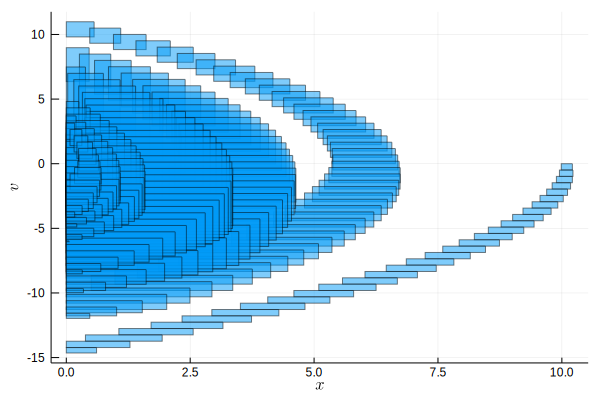

In [16]:
plot(sol, xlab=L"x", ylab=L"v", alpha=.5)

In [12]:
opC = BFFPSV18(Options(:δ=>0.1))
opD = LazyDiscretePost()
sol = solve(BouncingBall, Options(:T=>10.0, :project_reachset=>false, :plot_vars=>[1, 2], :max_jumps=>1), opC, opD);

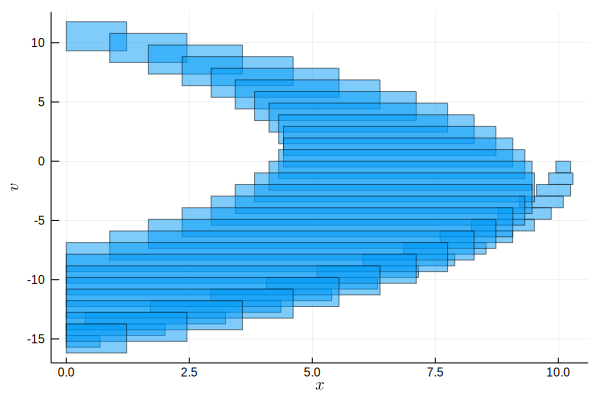

In [13]:
plot(sol, xlab=L"x", ylab=L"v", alpha=.5)

## Property checking

Let the set of *bad states* be the set of all states where $v \geq 10.7$.

In [14]:
BadStates = HalfSpace([0.0, -1.0], -10.7); # v >= 10.7